<a href="https://colab.research.google.com/github/Munna-Prasad-Gupta/nlp/blob/main/Quora_QuestionPairs_Similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install Distance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for Distance: filename=Distance-0.1.3-py3-none-any.whl size=16256 sha256=8324aff9aaaa3c8cf2d1cde2ab2da83fc9f82aadcf8f44f4376091717272c4a9
  Stored in directory: /root/.cache/pip/wheels/e8/bb/de/f71bf63559ea9a921059a5405806f7ff6ed612a9231c4a9309
Successfully built Distance


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
%pylab
import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

Using matplotlib backend: <object object at 0x7ab2b2e0fb00>
Populating the interactive namespace from numpy and matplotlib


In [3]:
#importing the data
df = pd.read_csv("questions.csv")

In [4]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404351 entries, 0 to 404350
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404351 non-null  int64 
 1   qid1          404351 non-null  int64 
 2   qid2          404351 non-null  int64 
 3   question1     404350 non-null  object
 4   question2     404349 non-null  object
 5   is_duplicate  404351 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [8]:
df.groupby("is_duplicate")['id'].count().plot.bar()
plt.show()

In [9]:
print("Percentage Question pairs that are not duplicates is", round(df[df['is_duplicate']==0].size/df.size *100  ,2))
print("Percentage Question pairs that are duplicates is", round(df[df['is_duplicate']==1].size/df.size *100  ,2))

Percentage Question pairs that are not duplicates is 63.08
Percentage Question pairs that are duplicates is 36.92


In [11]:
qids= pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_ids= len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print("Number of unique questions is ", unique_ids)
print("Number of unique questions that appear more than ones is ",np.sum(qids.value_counts()>1)," (", (np.sum(qids.value_counts()>1)) /(unique_ids) *100 ,")")
print("Number of unique questions that appear more than ones is ",np.max(qids.value_counts()))

q_values = qids.value_counts()

q_values= qids.values

Number of unique questions is  789801
Number of unique questions that appear more than ones is  13698  ( 1.7343609339567814 )
Number of unique questions that appear more than ones is  50


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

x = ["unique_questions", "Repeated Questions"]
y = [unique_ids, qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title("Plot representing unique and repeated questions")
sns.barplot(x=x, y=y)  # Pass x and y as keyword arguments
plt.show()


In [14]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions -3


In [16]:

#plotting a figure for the freqeuncy of different questions
plt.figure(figsize(15,7))
plt.hist( qids.value_counts(),bins=160)
plt.yscale('log',  )
plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')
plt.show()

In [22]:
# Dealing with null values
df[df.isnull().any(axis=1)]


,id,qid1,qid2,question1,question2,is_duplicate
105796,105796,209841,209842,How can I develop android app?,NaN,0
201871,201871,398348,398349,How can I create an Android app?,NaN,0
363416,363416,711434,711435,NaN,My Chinese name is Haichao Yu. What English na...,0


In [24]:
# Filling null values with an empty string
df = df.fillna('')

# Verify if there are any null values left (should return an empty DataFrame)
df[df.isnull().any(axis=1)]


,id,qid1,qid2,question1,question2,is_duplicate


Basic Feature Extraction (before cleaning)
Let us now construct a few features like:

____freq_qid1____ = Frequency of qid1's
____freq_qid2____ = Frequency of qid2's
____q1len____ = Length of q1
____q2len____ = Length of q2
____q1_n_words____ = Number of words in Question 1
____q2_n_words____ = Number of words in Question 2
____word_Common____ = (Number of common unique words in Question 1 and Question 2)
____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
____word_share____ = (word_common)/(word_Total)
____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2
____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2

In [25]:

#contructing the features
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
df['q1len'] = df['question1'].str.len()
df['q2len'] = df['question2'].str.len()
df['q1_n_words'] = df['question1'].apply(lambda row : len(str(row).split(' ')))
df['q2_n_words'] = df['question2'].apply(lambda row : len(str(row).split(' ')))

def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), str(row['question1']).split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), str(row['question2']).split(" ")))
        return 1.0 * len(w1 & w2)

df['word_Common'] = df.apply(normalized_word_Common, axis=1)

def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), str(row['question1']).split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), str(row['question2']).split(" ")))
        return 1.0 * (len(w1) + len(w2))
df['word_Total'] = df.apply(normalized_word_Total, axis=1)

def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), str(row['question1']).split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), str(row['question2']).split(" ")))
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
df['word_share'] = df.apply(normalized_word_share, axis=1)

df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,1,1,51,88,8,13,4.0,20.0,0.200000,2,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,1,1,76,39,13,7,2.0,20.0,0.100000,2,0


In [26]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 60
Number of Questions with minimum length [question2] : 25


In [27]:

#plot for feature word share
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

<ipython-input-27-9c086521abd9>:8: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-27-9c086521abd9>:9: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# First plot (Violin Plot)
plt.subplot(1, 2, 1)
sns.violinplot(x='is_duplicate', y='word_Common', data=df)

# Second plot (Histograms using histplot)
plt.subplot(1, 2, 2)
sns.histplot(df[df['is_duplicate'] == 1.0]['word_Common'], label="1", color='red', kde=True)
sns.histplot(df[df['is_duplicate'] == 0.0]['word_Common'], label="0", color='blue', kde=True)

plt.legend()  # Add legend for the two distributions
plt.show()


Preprocessing

In [32]:
!pip install fuzzywuzzy
!pip install python-Levenshtein

import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
import distance
import nltk
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 29.6 MB/s eta 0:00:00


In [34]:
df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
df = df.fillna('')
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,1,1,51,88,8,13,4.0,20.0,0.200000,2,0


In [37]:
import nltk
nltk.download('stopwords')
# To get the results in 4 decemal points
SAFE_DIV = 0.0001
STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)


    porter = PorterStemmer()
    pattern = re.compile('\W')

    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)


    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()


    return x

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [38]:
def get_token_features(q1,q2):
   token_features =[0.0] *10
   #converting the sentence into tokens
   q1_tokens= q1.split()
   q2_tokens= q2.split()

   if len(q1_tokens) == 0 or len(q2_tokens) ==0 :
    return token_features
  #Get non-stopwords in questions
   q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
   q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])

   #Get the stopwords in Questions
   q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
   q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])

   # Get the common non-stopwords from Question pair
   common_word_count = len(q1_words.intersection(q2_words))

   # Get the common stopwords from Question pair
   common_stop_count = len(q1_stops.intersection(q2_stops))

    # Get the common Tokens from Question pair
   common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))

   token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
   token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
   token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
   token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
   token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
   token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)

   # Last word of both question is same or not
   token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])

    # First word of both question is same or not
   token_features[7] = int(q1_tokens[0] == q2_tokens[0])

   token_features[8] = abs(len(q1_tokens) - len(q2_tokens))

   #Average Token Length of both Questions
   token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
   return token_features

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)



def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")

    # Merging Features with dataset

    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)

    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))




    #Computing Fuzzy Features and Merging with Dataset
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy


    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [40]:
df = pd.read_csv("questions.csv")
df = extract_features(df)
df.to_csv("nlp_features_train.csv", index=False)

token features...
fuzzy features..


In [41]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


In [42]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 298612
Number of data points in class 0 (non duplicate pairs) : 510090


In [43]:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16113348
Total number of words in non duplicate pair questions : 33193585


Word Cloud for Duplicate Question pairs


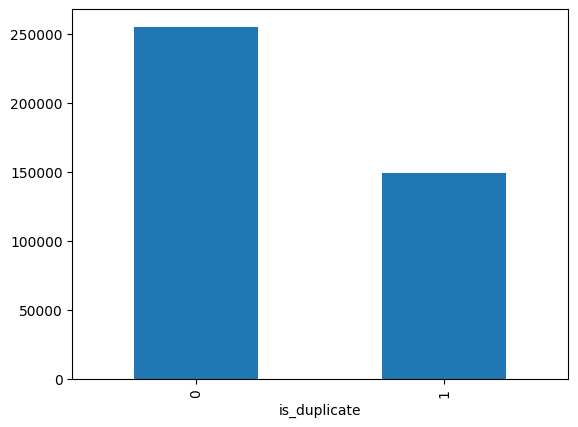

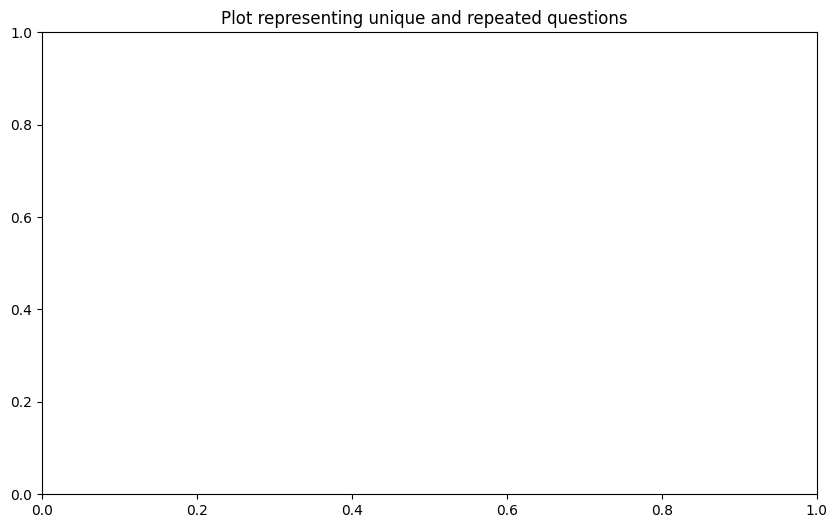

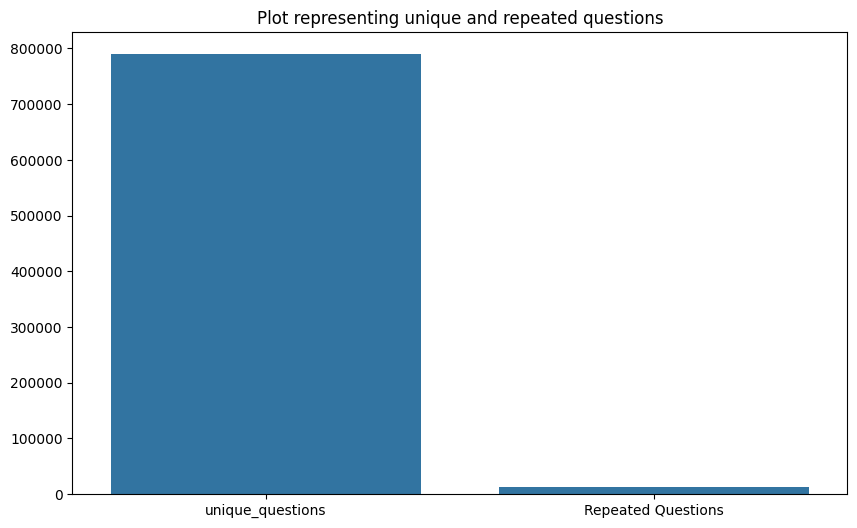

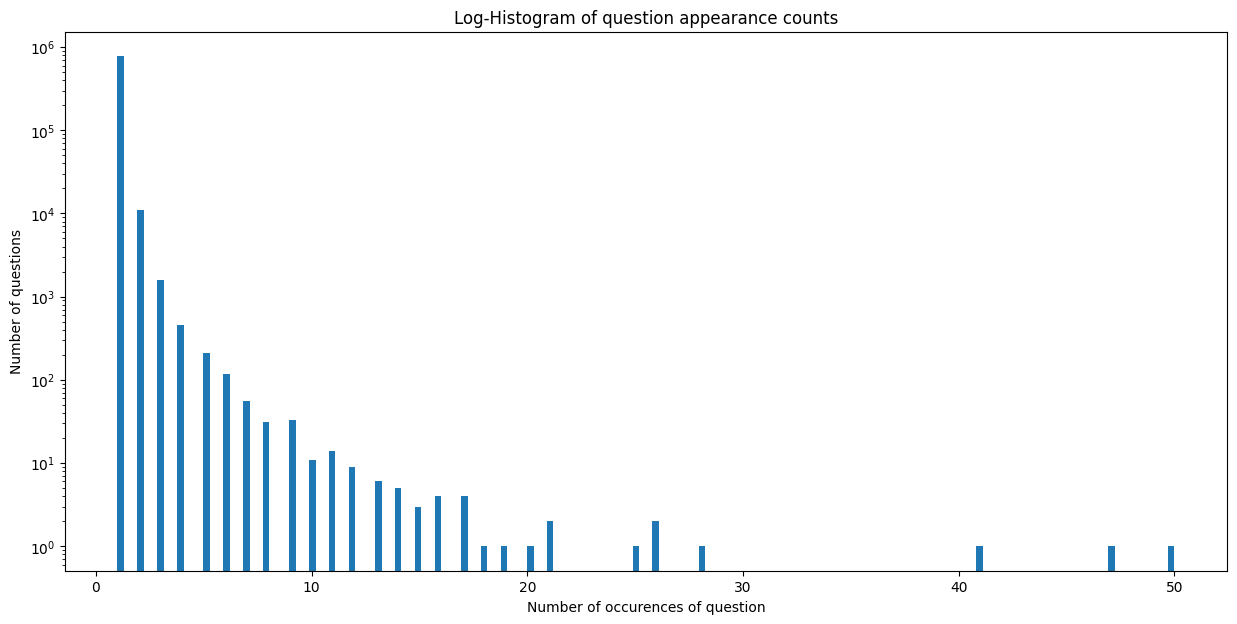

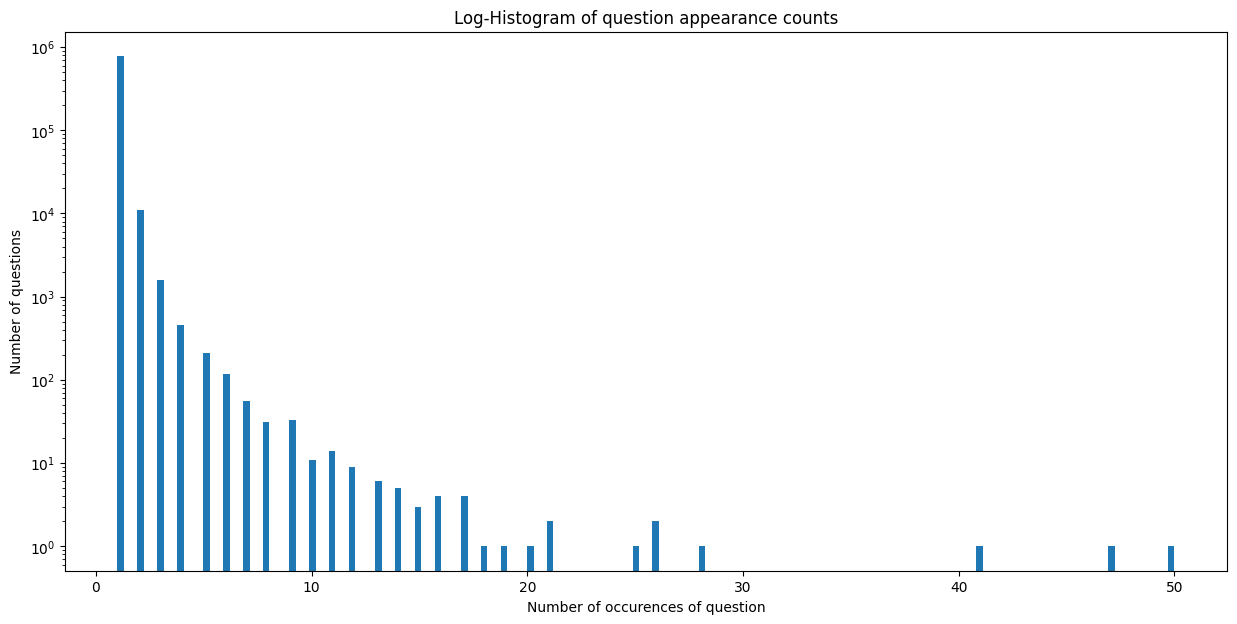

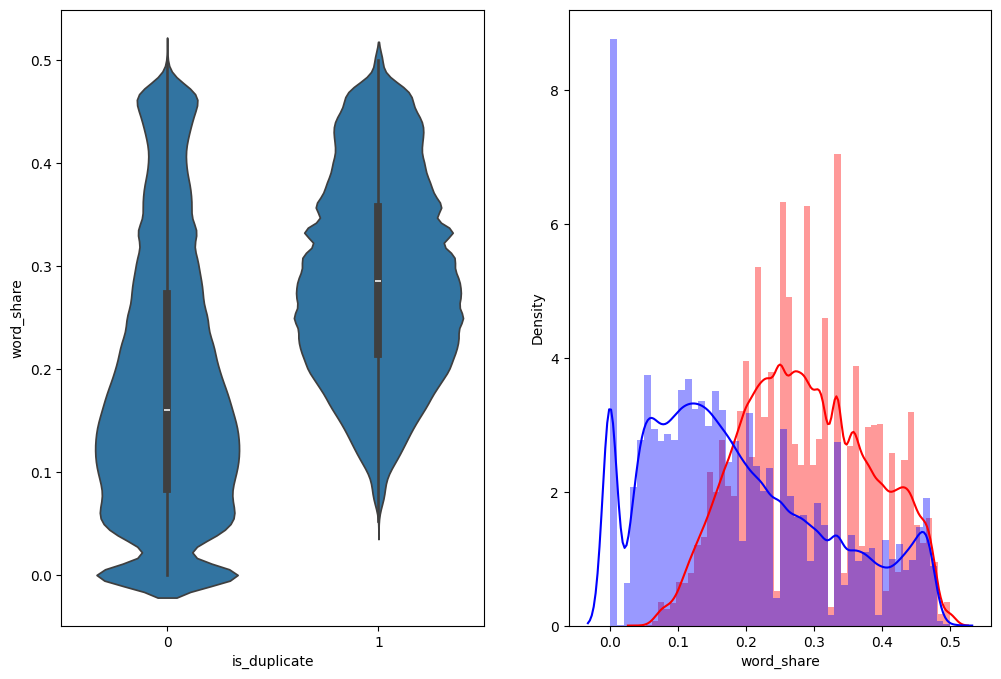

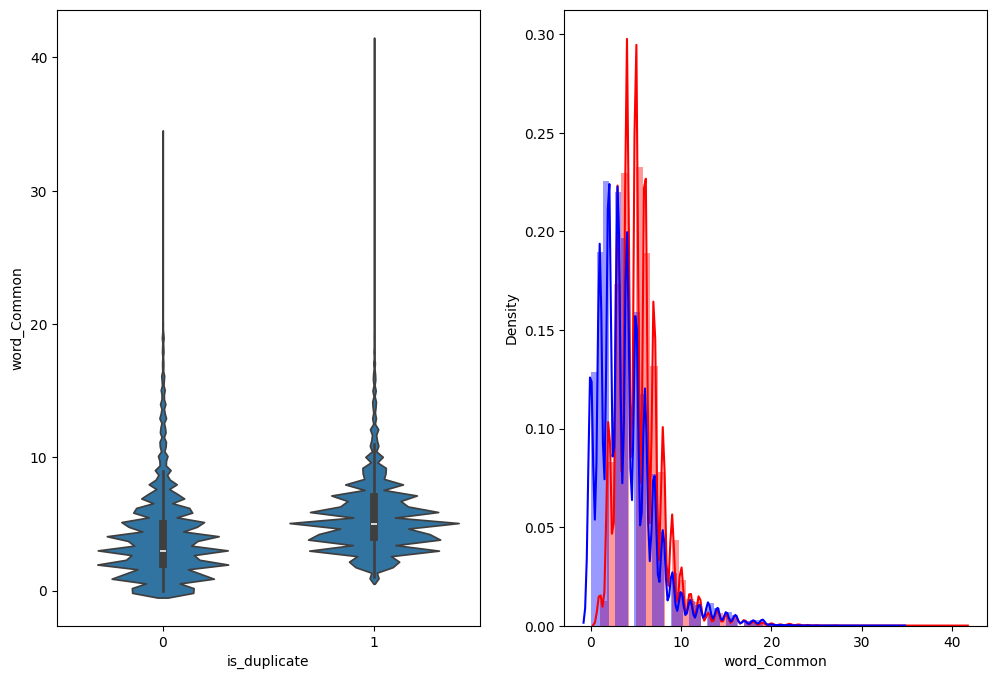

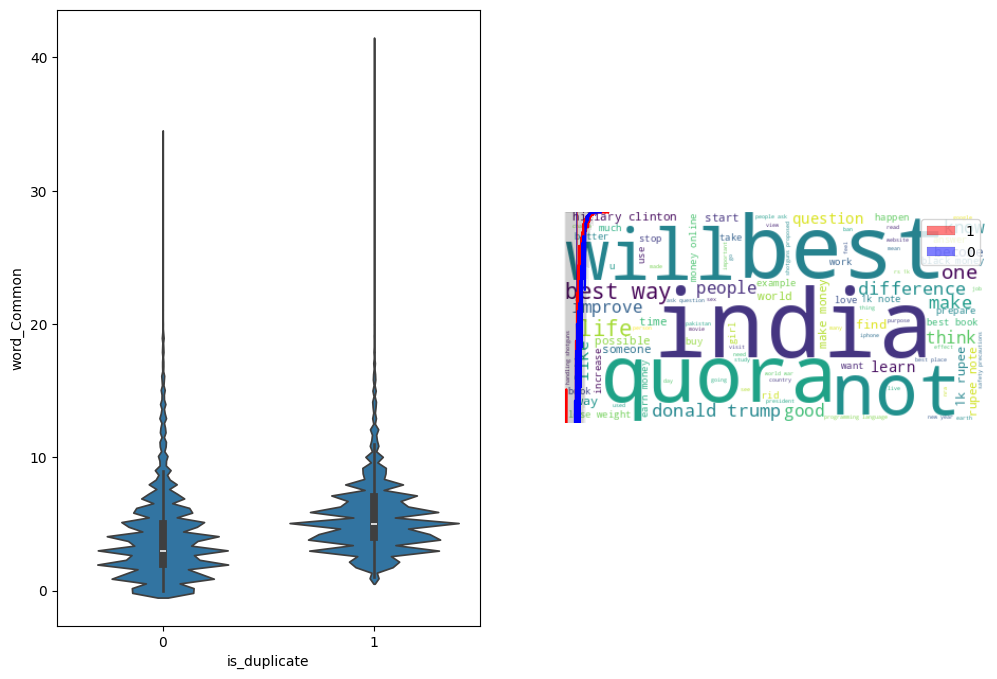

In [44]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for Duplicate Question pairs


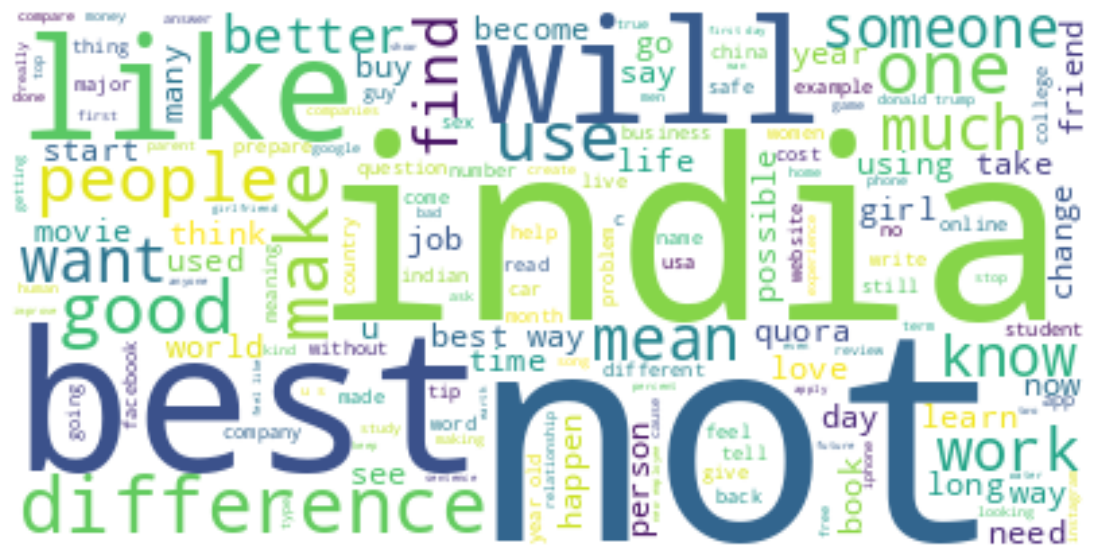

In [45]:
wc = WordCloud(background_color="white", max_words=len(textn_w), stopwords=stopwords)
wc.generate(textn_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

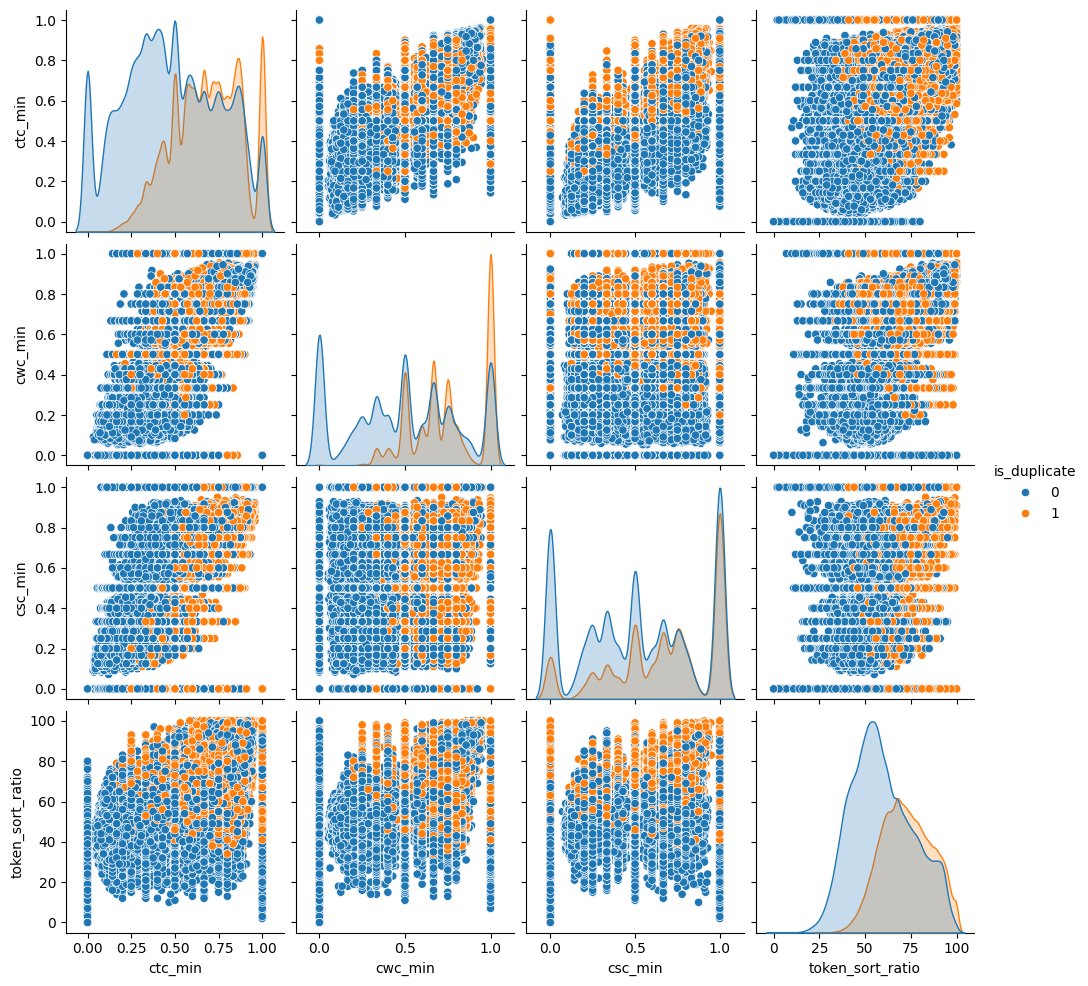

In [46]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

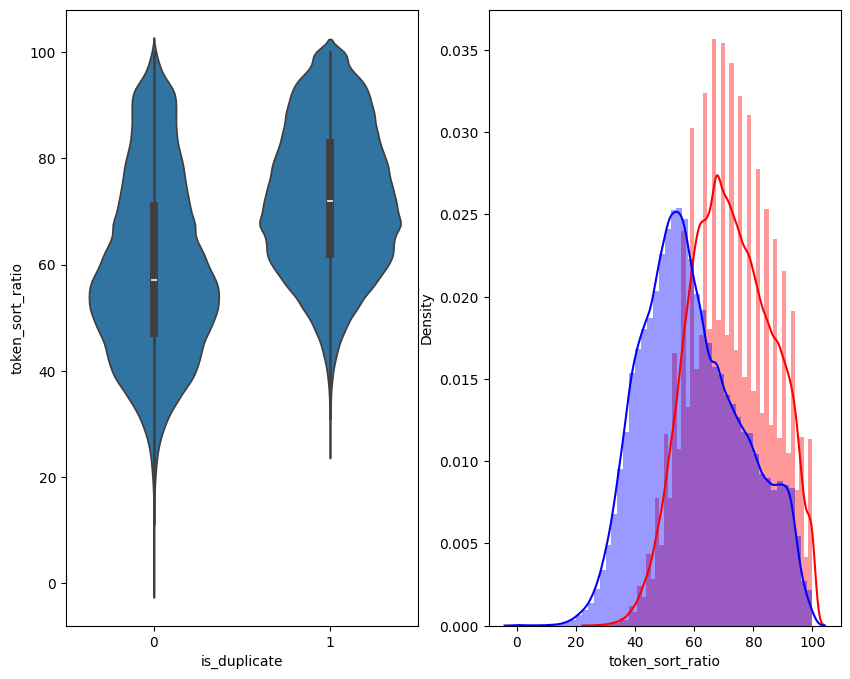

In [47]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

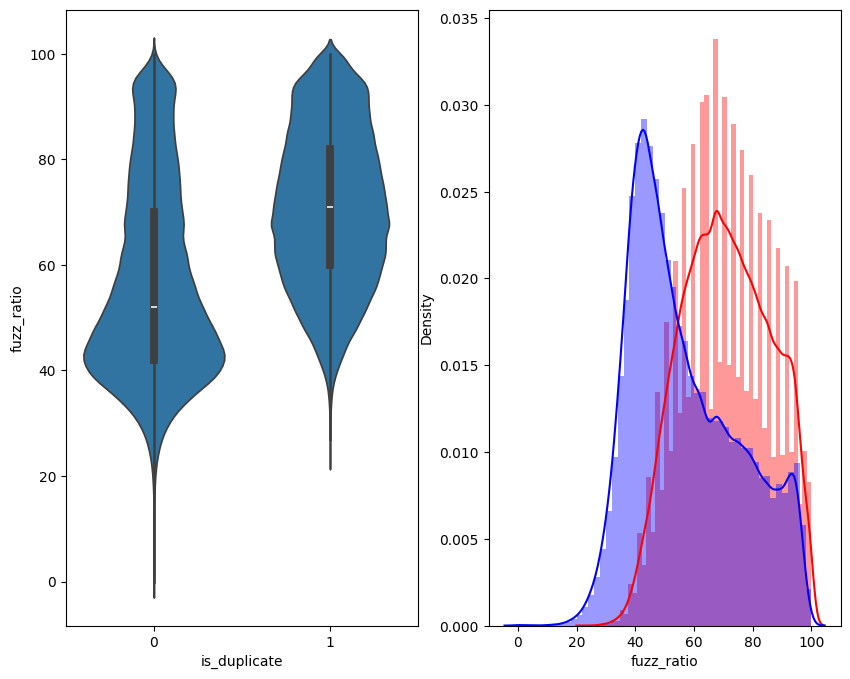

In [48]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

In [49]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [50]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.029s...
[t-SNE] Computed neighbors for 5000 samples in 0.380s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116477
[t-SNE] Computed conditional probabilities in 0.162s
[t-SNE] Iteration 50: error = 85.9592514, gradient norm = 0.0950990 (50 iterations in 3.277s)
[t-SNE] Iteration 100: error = 70.8189850, gradient norm = 0.0137380 (50 iterations in 3.077s)
[t-SNE] Iteration 150: error = 68.7101059, gradient norm = 0.0075265 (50 iterations in 1.903s)
[t-SNE] Iteration 200: error = 67.7651901, gradient norm = 0.0056494 (50 iterations in 1.964s)
[t-SNE] Iteration 250: error = 67.2502289, gradient norm = 0.0043632

In [51]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

Featurizing text data with tfidf weighted word-vectors

In [52]:

import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy

In [53]:
df= pd.read_csv("questions.csv")

df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

AttributeError: 'TfidfVectorizer' object has no attribute 'get_feature_names'

In [ ]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1)
    # 384 is the number of dimensions of vectors
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)

In [ ]:
vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2)
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

In [ ]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
dfnlp = pd.read_csv("/content/drive/My Drive/Quora/nlp_features_train.csv",encoding='latin-1')
dfppro = pd.read_csv("/content/drive/My Drive/Quora/df_fe_without_preprocessing_train.csv",encoding='latin-1')

In [ ]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [ ]:
# dataframe of nlp features
df1.head()

In [ ]:
# data before preprocessing
df2.head()

In [ ]:

# Questions 1 tfidf weighted word2vec
df3_q1.head()

In [ ]:

print("Number of features in nlp dataframe :", df1.shape[1])
print("Number of features in preprocessed dataframe :", df2.shape[1])
print("Number of features in question1 w2v  dataframe :", df3_q1.shape[1])
print("Number of features in question2 w2v  dataframe :", df3_q2.shape[1])
print("Number of features in final dataframe  :", df1.shape[1]+df2.shape[1]+df3_q1.shape[1]+df3_q2.shape[1])

In [ ]:
#saving the data fram
df3_q1['id']=df1['id']
df3_q2['id']=df1['id']
df1  = df1.merge(df2, on='id',how='left')
df2  = df3_q1.merge(df3_q2, on='id',how='left')
result  = df1.merge(df2, on='id',how='left')
result.to_csv('final_features.csv')

Model training

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [ ]:
disk_engine = create_engine('sqlite:///train.db')


df= pd.read_csv("final_features.csv")
df[0:100000].to_sql('data', disk_engine, if_exists='append')


#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)

    return None


def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall()
    print(tables[0][0])
    return(len(tables))

In [ ]:
read_db = 'train.db'
conn_r = create_connection(read_db)
checkTableExists(conn_r)
conn_r.close()

In [ ]:
conn_r = create_connection(read_db)
data = pd.read_sql_query("SELECT * From data ORDER BY RANDOM() LIMIT 10001;", conn_r)
conn_r.commit()
conn_r.close()

In [ ]:

# remove the first row
data.drop(data.index[0], inplace=True)
y_true = data['is_duplicate']
data.drop(['Unnamed: 0', 'id','index','is_duplicate'], axis=1, inplace=True)

In [ ]:
data.head()

In [ ]:

# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = list(data.columns)
for i in cols:
    data[i] = data[i].apply(pd.to_numeric)
    #print(i)

In [ ]:
# https://stackoverflow.com/questions/7368789/convert-all-strings-in-a-list-to-int
y_true = list(map(int, y_true.values))

In [ ]:
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

In [ ]:

print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

In [ ]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

In [ ]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j

    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column

    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1

    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]]
    plt.figure(figsize=(20,4))

    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")

    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")

    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")

    plt.show()


In [ ]:
import scikitplot.metrics as skplt




# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))
predicted_y =np.argmax(predicted_y, axis=1)


plot_confusion_matrix(y_test, predicted_y)
plt.show()

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)


In [ ]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.




log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [ ]:
import xgboost as xgb
param_grid = {"max_depth":[x for x in range(2,10)],
              "n_estimators":[50,100,150,200,300,400,500]}

In [ ]:
model = RandomizedSearchCV(xgb.XGBClassifier(n_jobs=-1,random_state=25), param_distributions=param_grid,n_iter=30,scoring='neg_log_loss',cv=3,n_jobs=-1)


In [ ]:
model.fit(X_train,y_train)

In [ ]:
model.best_params_

In [ ]:
clf=xgb.XGBClassifier(n_jobs=-1,random_state=25,max_depth=6,n_estimators=50)

In [ ]:
clf.fit(X_train,y_train)

In [ ]:
y_pred_test=clf.predict_proba(X_test)
y_pred_train=clf.predict_proba(X_train)
log_loss_train = log_loss(y_train, y_pred_train, eps=1e-15)
log_loss_test=log_loss(y_test,y_pred_test,eps=1e-15)
print('Train log loss = ',log_loss_train,' Test log loss = ',log_loss_test)
predicted_y=np.argmax(y_pred_test,axis=1)
plot_confusion_matrix(y_test,predicted_y)